In [50]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#most of this code is taken from or heavily inspired by Week 5 example 3 and Week 5 prac Q1

In [76]:
#Load the data
train = loadmat('/Users/catherinexu/Documents/QUT/ML/Data/Q3/q3_train.mat')
test = loadmat('/Users/catherinexu/Documents/QUT/ML/Data/Q3/q3_test.mat')
X_train = train['train_X']
Y_train = train['train_Y']
print(len(X_train))
X_test = test['test_X']
Y_test = test['test_Y']
Y_train = Y_train - 1
Y_test = Y_test - 1
print(np.max(X_train))
print(np.max(Y_test))


32
255
9


In [77]:
#Following code from tutor ethan in slack
#Reshape the training set
print('input shape before = {}'.format(X_train.shape))
# also plotting it to make sure we reshaped everything correctly
X_train = np.swapaxes(X_train, 3, 0)
print('input first swap = {}'.format(X_train.shape))
X_train = np.swapaxes(X_train, 3, 1)
print('input first swap = {}'.format(X_train.shape))
X_train = np.swapaxes(X_train, 3, 2)
print('input final = {}'.format(X_train.shape))

input shape before = (32, 32, 3, 1000)
input first swap = (1000, 32, 3, 32)
input first swap = (1000, 32, 3, 32)
input final = (1000, 32, 32, 3)


input shape before = (32, 32, 3, 10000)
input first swap = (10000, 32, 3, 32)
input first swap = (10000, 32, 3, 32)
input final = (10000, 32, 32, 3)


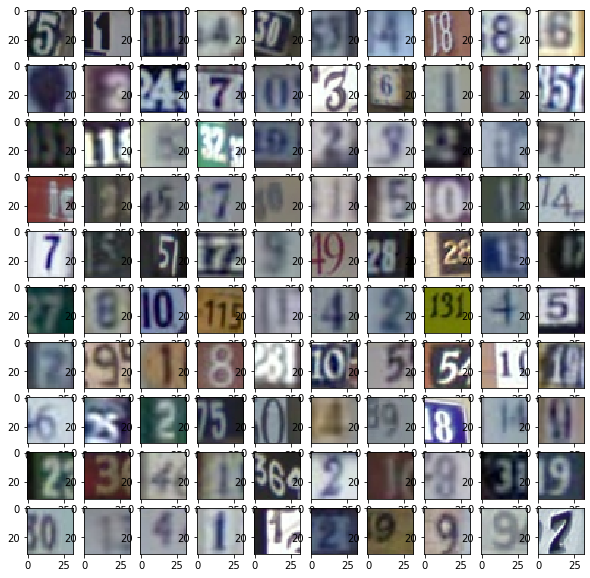

In [78]:
#Reshape the testing set in the same manner
print('input shape before = {}'.format(X_test.shape))
# also plotting it to make sure we reshaped everything correctly
X_test = np.swapaxes(X_test, 3, 0)
print('input first swap = {}'.format(X_test.shape))
X_test = np.swapaxes(X_test, 3, 1)
print('input first swap = {}'.format(X_test.shape))
X_test = np.swapaxes(X_test, 3, 2)
print('input final = {}'.format(X_test.shape))

#  plotting it to make sure we reshaped everything correctly
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    # If these were full colour RGB images, this would not be needed
    ax.imshow(X_test[i,:,:, :])
plt.show()

In [34]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train

array([[[[0.2901961 , 0.25490198, 0.21568628],
         [0.29411766, 0.2627451 , 0.22352941],
         [0.3019608 , 0.27450982, 0.23529412],
         ...,
         [0.09803922, 0.09411765, 0.08627451],
         [0.10980392, 0.10588235, 0.09803922],
         [0.11372549, 0.10980392, 0.10196079]],

        [[0.2509804 , 0.21568628, 0.18431373],
         [0.25490198, 0.21960784, 0.1882353 ],
         [0.25490198, 0.23137255, 0.19215687],
         ...,
         [0.09803922, 0.09411765, 0.09019608],
         [0.10588235, 0.10196079, 0.09803922],
         [0.10980392, 0.10588235, 0.10196079]],

        [[0.18431373, 0.15686275, 0.12941177],
         [0.18039216, 0.15686275, 0.12941177],
         [0.1764706 , 0.16078432, 0.1254902 ],
         ...,
         [0.10588235, 0.09803922, 0.10196079],
         [0.10588235, 0.09803922, 0.10196079],
         [0.10588235, 0.09803922, 0.10196079]],

        ...,

        [[0.10196079, 0.07450981, 0.04705882],
         [0.10196079, 0.07843138, 0.05098039]

In [35]:
#Let's look at the network itself, we are building a classification model to classify number from 1-10
#This code is taken from practical 4
#We start with defining the numbr of epochs and then we build the model
def build_model(num_classes):
    # our model, input in an image shape
    inputs = keras.Input(shape=(32, 32, 3, ), name='X_train')
    
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    
    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_cnn_model')
    
    return model_cnn

model_cnn = build_model(10)
model_cnn.summary()

Model: "SVHN_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_train (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 8)      

In [36]:
#train the basic moodel
num_epochs = 50
#compile function configures the model for training
#metrics determines what we wish to evaluate on, here accuracy
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])
history = model_cnn.fit(x=X_train, y=Y_train, batch_size = 50, 
              epochs = num_epochs, 
              validation_data = (X_test, Y_test))

Train on 1000 samples, validate on 10000 samples
Epoch 1/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 2.4703 - accuracy: 0.1090 - val_loss: 2.2981 - val_accuracy: 0.1086
Epoch 2/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 2.3486 - accuracy: 0.1300 - val_loss: 2.2930 - val_accuracy: 0.1550
Epoch 3/50
1000/1000 [==============================] - 7s 7ms/sample - loss: 2.2805 - accuracy: 0.1550 - val_loss: 2.2756 - val_accuracy: 0.1894
Epoch 4/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 2.2751 - accuracy: 0.1610 - val_loss: 2.2628 - val_accuracy: 0.1894
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/sample - loss: 2.2436 - accuracy: 0.1670 - val_loss: 2.2538 - val_accuracy: 0.1894
Epoch 6/50
1000/1000 [==============================] - 4s 4ms/sample - loss: 2.2366 - accuracy: 0.1670 - val_loss: 2.2466 - val_accuracy: 0.1688
Epoch 7/50
1000/1000 [==============================] - 5s 5ms/sample - los

10000/10000 - 3s - loss: 0.6957 - accuracy: 0.8275
Test loss: 0.695667024731636
Test accuracy: 0.8275


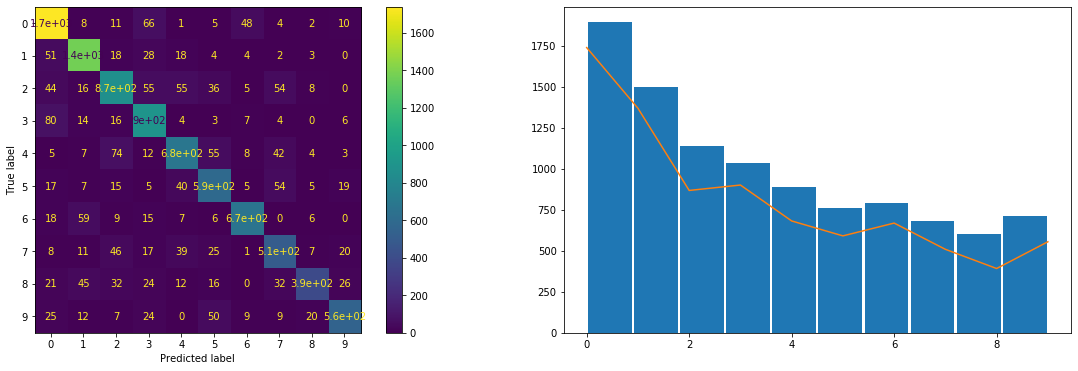

In [37]:
#Using eval_model from week 4 to evaluate model in a confusion matrix
def eval_model(model, X_test, Y_test):
    test_scores = model.evaluate(X_test, Y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(X_test);
    indexes = tensorflow.argmax(pred, axis=1)

    cm = confusion_matrix(Y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(Y_test, bins=len(np.diagonal(cm)), rwidth=0.95)
    ax.plot(np.diagonal(cm))

eval_model(model_cnn, X_test, Y_test)

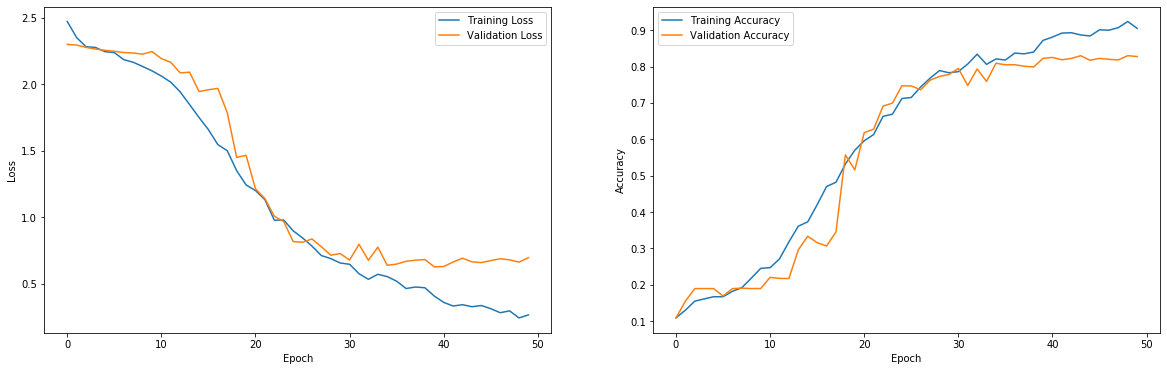

In [38]:
#Use data augmentation to give ourselves a bigger
#training set with more samples
#First let's have a look at loss and accuracy in out baseline model, and then compare baseline to the new
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.legend()

10000/10000 - 3s - loss: 0.6957 - accuracy: 0.8275
Test loss: 0.695667024731636
Test accuracy: 0.8275


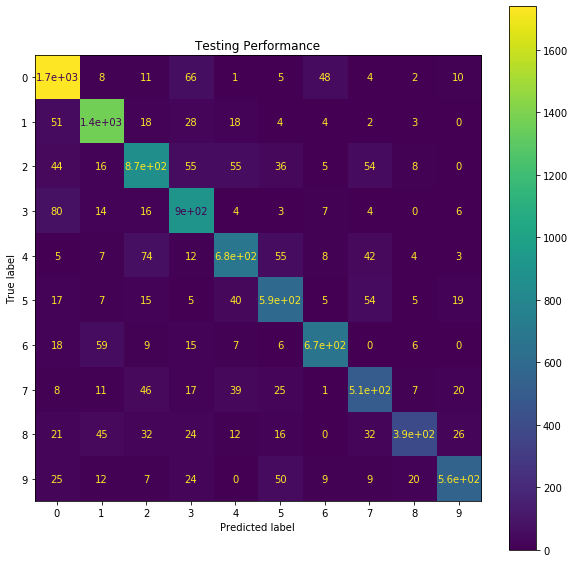

In [39]:
#Look at the confusion matrix
test_scores = model_cnn.evaluate(X_test, Y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
pred = model_cnn.predict(X_test);
indexes = tensorflow.argmax(pred, axis=1)
cm = confusion_matrix(Y_test, indexes)
c = ConfusionMatrixDisplay(cm, display_labels=range(10))
c.plot(ax = ax)    
ax.set_title('Testing Performance');

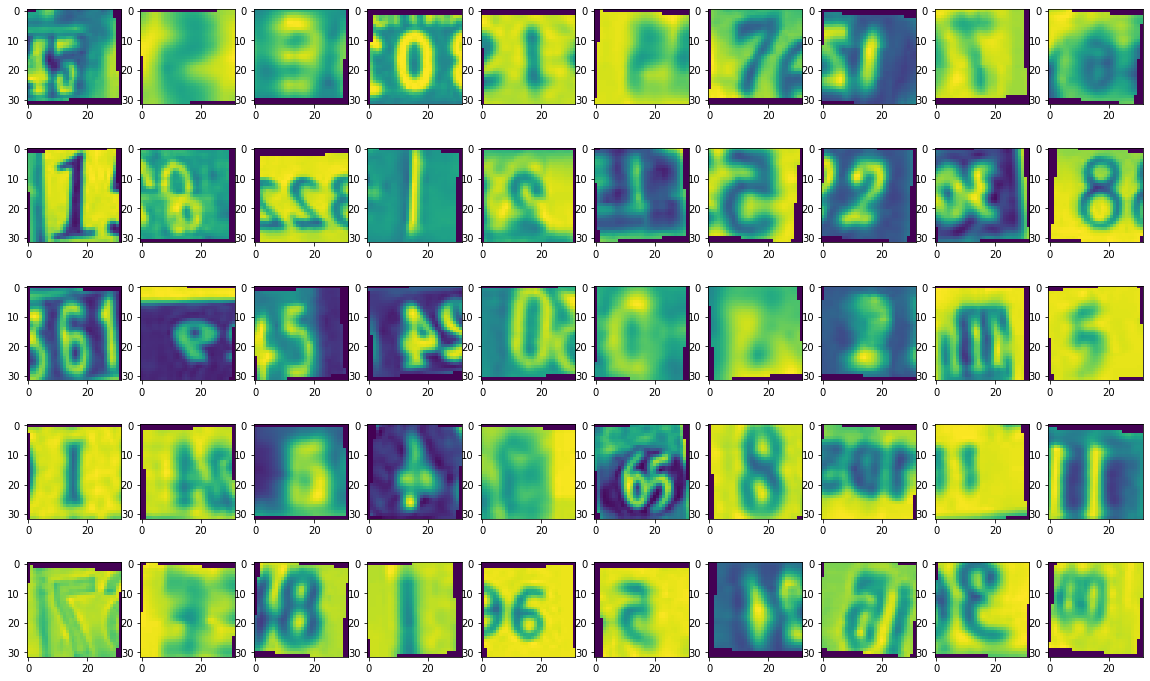

In [41]:
#And now we add some data augmentation
#many possibilities, I will zoom, vertical shift and horisontal shift
data_gen = ImageDataGenerator(
                            # rotate between -5, +5 degrees
                            rotation_range=5,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for randomly applying a shearing transform
                            shear_range=0.05,
                            # range for zooming
                            zoom_range=0.05,
                            # allow horizontal flips of data
                            horizontal_flip=True,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)


batch = data_gen.flow(X_train, Y_train, batch_size=50)
fig = plt.figure(figsize=[20, 25])
for i,img in enumerate(batch[0][0]):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(img[:,:,0])

In [42]:
model_cnn = build_model(10)
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(),#(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
history = model_cnn.fit_generator(data_gen.flow(X_train, Y_train, batch_size=50),
                    epochs=100,
                    validation_data=(X_test, Y_test), verbose=False)

  ...
    to  
  ['...']


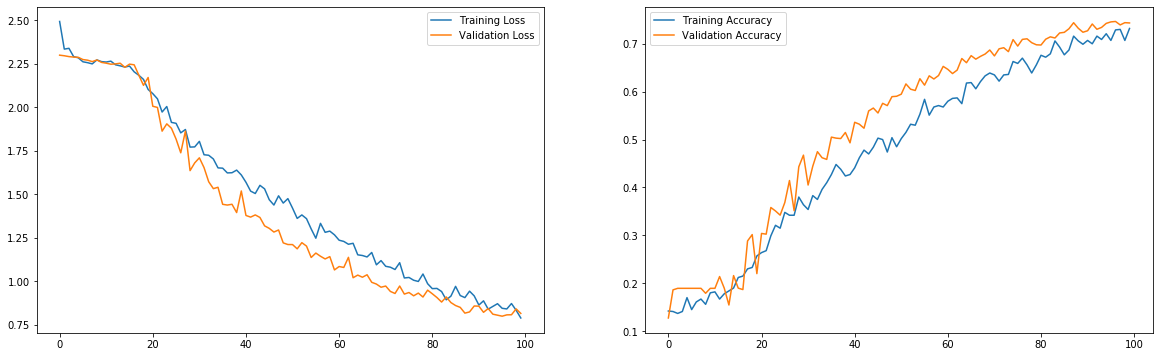

In [21]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.legend()

10000/10000 - 3s - loss: 0.8160 - accuracy: 0.7435
Test loss: 0.8160149386405945
Test accuracy: 0.7435


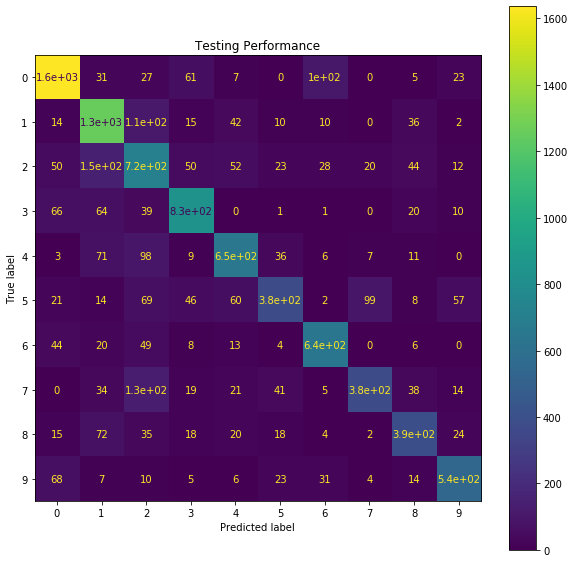

In [27]:
test_scores = model_cnn.evaluate(X_test, Y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
pred = model_cnn.predict(X_test);
indexes = tensorflow.argmax(pred, axis=1)
cm = confusion_matrix(Y_test, indexes)
c = ConfusionMatrixDisplay(cm, display_labels=range(10))
c.plot(ax = ax)    
ax.set_title('Testing Performance');

In [52]:
#Fine tuning

In [53]:
#Load a pretrained model provided in Blackboard resources
#I'm using a ResNet on CIFAR because the input shape of CIFAR matches mine
#I will tune one layer first
model = keras.models.load_model('/Users/catherinexu/Documents/QUT/ML/trained_models_keras_ResNet/resnet_v2_cifar_big.h5')
model.summary()

Model: "large_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 32, 32, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_239 (BatchN (None, 32, 32, 32)   128         conv2d_275[0][0]                 
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 32, 32, 32)   0           batch_normalization_239[0][0]    
____________________________________________________________________________________

In [55]:
#Still want to classify on 10 classes
outputs = layers.Dense(10, activation = 'softmax')(model.layers[-2].output)
new_model = keras.Model(inputs = model.input, outputs=outputs)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 32, 32, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_239 (BatchN (None, 32, 32, 32)   128         conv2d_275[0][0]                 
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 32, 32, 32)   0           batch_normalization_239[0][0]    
____________________________________________________________________________________________

In [57]:
#Freeze layers except the last 1 layers, which is the dense layer
for layer in new_model.layers[:-1]:
    layer.trainable = False

#Check the trainable status of all the individual layers
for layer in new_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1a444e2c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1a444e2c90> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1a444d5710> False
<tensorflow.python.keras.layers.core.Activation object at 0x1a444d5c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1a444d5d50> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1a444dd3d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x1a444e2c10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1a444dd990> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x1a444ddfd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x1a444cc510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1a444cc610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0

In [66]:
new_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(X_train, Y_train,
                        batch_size=50,
                        epochs=30,
                        validation_data=(X_test, Y_test))

Train on 1000 samples, validate on 10000 samples
Epoch 1/30
1000/1000 [==============================] - 46s 46ms/sample - loss: 2.5028 - accuracy: 0.2440 - val_loss: 137.2926 - val_accuracy: 0.1497
Epoch 2/30
1000/1000 [==============================] - 43s 43ms/sample - loss: 2.4884 - accuracy: 0.2600 - val_loss: 137.8988 - val_accuracy: 0.1497
Epoch 3/30
1000/1000 [==============================] - 52s 52ms/sample - loss: 2.4760 - accuracy: 0.2510 - val_loss: 135.1014 - val_accuracy: 0.1497
Epoch 4/30
1000/1000 [==============================] - 55s 55ms/sample - loss: 2.4628 - accuracy: 0.2550 - val_loss: 136.5419 - val_accuracy: 0.1497
Epoch 5/30
1000/1000 [==============================] - 48s 48ms/sample - loss: 2.4488 - accuracy: 0.2620 - val_loss: 136.3369 - val_accuracy: 0.1497
Epoch 6/30
1000/1000 [==============================] - 42s 42ms/sample - loss: 2.4437 - accuracy: 0.2620 - val_loss: 134.8697 - val_accuracy: 0.1497
Epoch 7/30
1000/1000 [=============================

10000/10000 - 46s - loss: 123.6784 - accuracy: 0.1518
Test loss: 123.6783623046875
Test accuracy: 0.1518


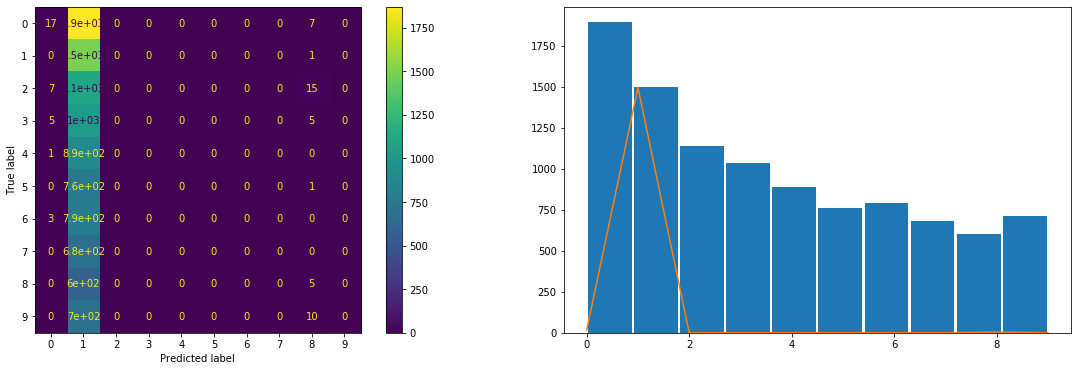

In [67]:
eval_model(new_model, X_test, Y_test)

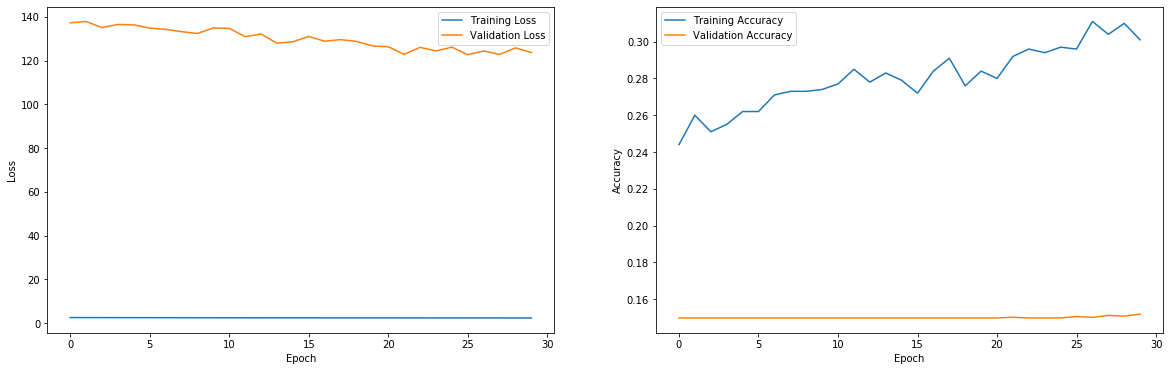

In [68]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.legend()

In [69]:
#there's something fatal going on here
#I will use the same network and tune more layers this time
#I will tune one layer first
model = keras.models.load_model('/Users/catherinexu/Documents/QUT/ML/trained_models_keras_ResNet/resnet_v2_cifar_big.h5')
model.summary()

Model: "large_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 32, 32, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_239 (BatchN (None, 32, 32, 32)   128         conv2d_275[0][0]                 
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 32, 32, 32)   0           batch_normalization_239[0][0]    
____________________________________________________________________________________

In [70]:
#Still want to classify on 10 classes
outputs = layers.Dense(10, activation = 'softmax')(model.layers[-2].output)
new_model = keras.Model(inputs = model.input, outputs=outputs)
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 32, 32, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_239 (BatchN (None, 32, 32, 32)   128         conv2d_275[0][0]                 
__________________________________________________________________________________________________
activation_239 (Activation)     (None, 32, 32, 32)   0           batch_normalization_239[0][0]    
____________________________________________________________________________________________

In [71]:
#Now I won't freeze any layers, hence I will train the whole network
new_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history = new_model.fit(X_train, Y_train,
                        batch_size=50,
                        epochs=30,
                        validation_data=(X_test, Y_test))

Train on 1000 samples, validate on 10000 samples
Epoch 1/30
1000/1000 [==============================] - 73s 73ms/sample - loss: 2.7095 - accuracy: 0.1140 - val_loss: 2.7698 - val_accuracy: 0.0862
Epoch 2/30
1000/1000 [==============================] - 69s 69ms/sample - loss: 2.5570 - accuracy: 0.1900 - val_loss: 2.6327 - val_accuracy: 0.1323
Epoch 3/30
1000/1000 [==============================] - 61s 61ms/sample - loss: 2.4996 - accuracy: 0.2350 - val_loss: 2.6090 - val_accuracy: 0.1629
Epoch 4/30
1000/1000 [==============================] - 66s 66ms/sample - loss: 2.4605 - accuracy: 0.2590 - val_loss: 2.5472 - val_accuracy: 0.2178
Epoch 5/30
1000/1000 [==============================] - 66s 66ms/sample - loss: 2.4252 - accuracy: 0.2770 - val_loss: 2.5047 - val_accuracy: 0.2516
Epoch 6/30
1000/1000 [==============================] - 57s 57ms/sample - loss: 2.3862 - accuracy: 0.2960 - val_loss: 2.4727 - val_accuracy: 0.2510
Epoch 7/30
1000/1000 [==============================] - 55s 55m

10000/10000 - 45s - loss: 1.9853 - accuracy: 0.4230
Test loss: 1.9853471782684327
Test accuracy: 0.423


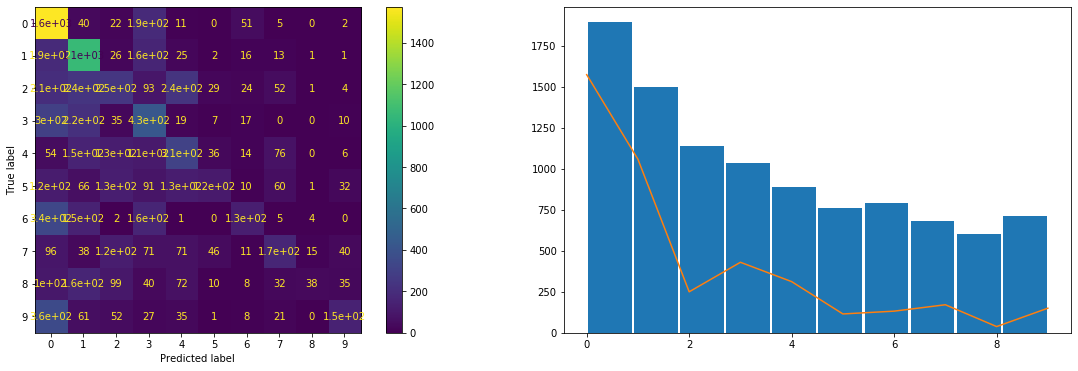

In [72]:
eval_model(new_model, X_test, Y_test)

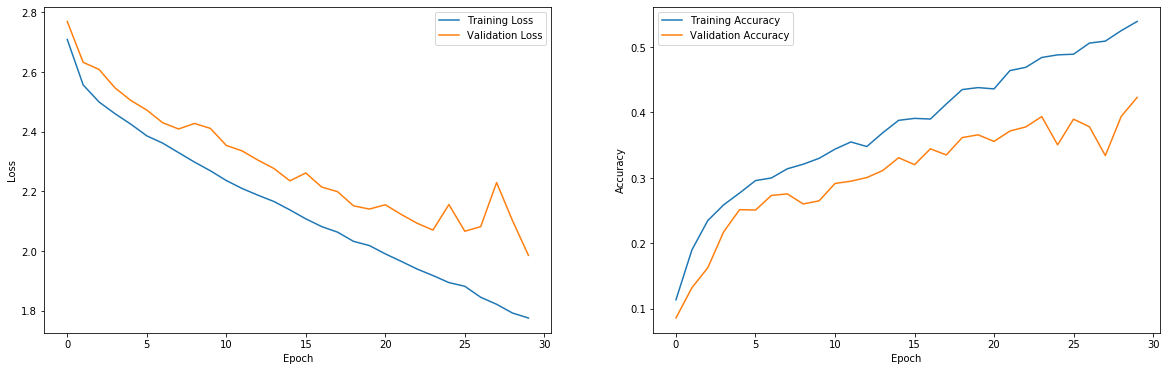

In [74]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.legend()